In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import *

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
sim = AerSimulator()

from util import zero, one, qft, amod15

# Shor's Part 4/5: Quantum Phase Estimation

**Quantum phase estimation** is an algorithm which when given a unitary matrix $U$ and an eigenvector $|u\rangle$, will produce the eigenvalue, i.e., the given phase $e^{2\pi i \phi}$.

References
1. [Introduction to Classical and Quantum Computing, Chapter 7.7 - 7.10](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf)
2. [https://qiskit.org/textbook/ch-algorithms/shor.html](https://qiskit.org/textbook/ch-algorithms/shor.html)
3. [https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)
3. [Introduction to Quantum Information Science: Lectures 20 and 21 by Scott Aaronson](https://www.scottaaronson.com/qclec.pdf)
4. [Quantum Computation and Quantum Information: Chapter 5, Nielsen and Chuang](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview)

## Building Blocks

QPE relies on two building blocks.
1. The first building block is a **controlled-U operator** which is a generalization of a controlled-NOT gate to an arbitrary unitary matrix $U$.
2. The second building block is the **inverse QFT** which is the inverse of the QFT.

## Algorithm Walkthrough

Suppose we are working with $n$ bits. In RSA, we would have $n = \log(N) = pq$.
Then the QPE algorithm consts of the following steps.

1. Initialize state $|u\rangle \otimes |0\rangle^{\otimes n}$ (little Endian) so that we have two registers of n bits.

We'll walkthrough the QPE algorithm using $n = 4$ now.

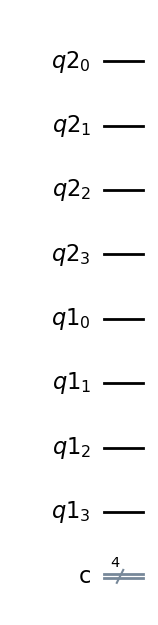

In [2]:
n_count = 4
f_qc_U = lambda q: amod15(7, q)
reg1_size = f_qc_U(0).num_qubits

reg1 = QuantumRegister(reg1_size, "q1")
reg2 = QuantumRegister(n_count, "q2")
output = ClassicalRegister(n_count, "c")

# qc = QuantumCircuit(n_count+reg1_size, n_count)
qc = QuantumCircuit(reg2, reg1, output)
qc.draw(output="mpl", style="iqp")

### Step 1

Initialize state $|u\rangle \otimes |0\rangle^{\otimes n}$ (little Endian) so that we have two registers of n bits.

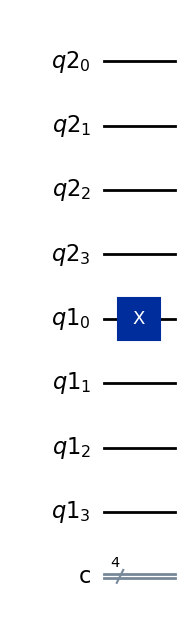

In [3]:
# Step 1: Prepare our eigenstate |1>:
qc.x(n_count)
qc.draw(output="mpl", style="iqp")

#### State after Step 1

\begin{align*}
|\psi_1\rangle & = (I^{\otimes 3} \otimes X \otimes I^{\otimes 4})|00000000\rangle \\
& = |00010000\rangle
\end{align*}

### Step 2

Apply $H^{\otimes t}$ to the first register.

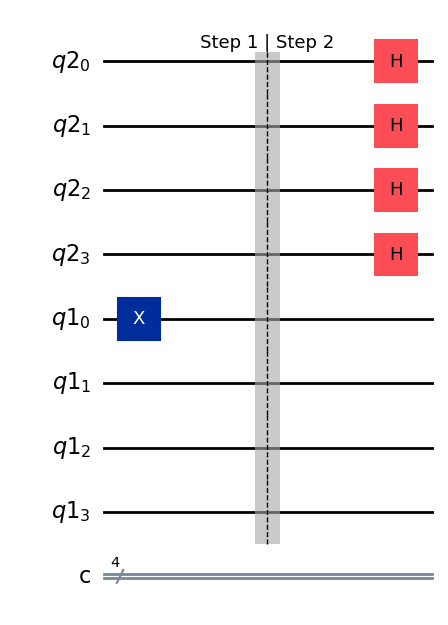

In [4]:
# Step 2: Apply H-Gates to counting qubits.
qc.barrier(label="Step 1 | Step 2")
for qubit in range(n_count):
    qc.h(qubit)
qc.draw(output="mpl", style="iqp")

#### State after Step 2

\begin{align*}
|\psi_2\rangle & = (I^{\otimes 4} \otimes H^{\otimes 4})|\psi_1\rangle \\
& = (I^{\otimes 4} \otimes H^{\otimes 4})|00010000\rangle \\
& = |0001++++\rangle
\end{align*}

### Step 3

Apply the **controlled-U operator** with control on the second register and targetting the first register.

#### Controlled U Operator

1. As a reminder, a controlled not gate $CNOT$ is a two-qubit gate that applies a not to the target qubit if the control qubit is set.
2. Similarly, a controlled $U^{2^t \times 2^t}$ operator is a $1+t$ qubit gate that applies $U$ to $t$ qubits if the control qubit is set.

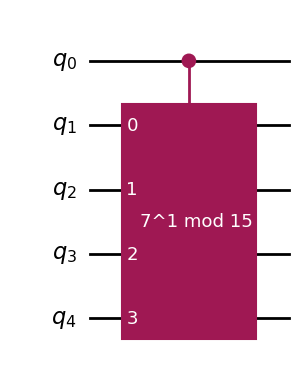

In [5]:
qc_cu = QuantumCircuit(1 + 4)
a = 7; q = 0
qc_cu.append(
    amod15(a, 2**q).control(),
    # [q] is control
    # [1+i for i in range(4)] is target
    [q] + [1+i for i in range(4)]
)
qc_cu.draw(output="mpl", style="iqp")

Returning to the QPE circuit, we'll apply a a sequence of controlled-U gates.

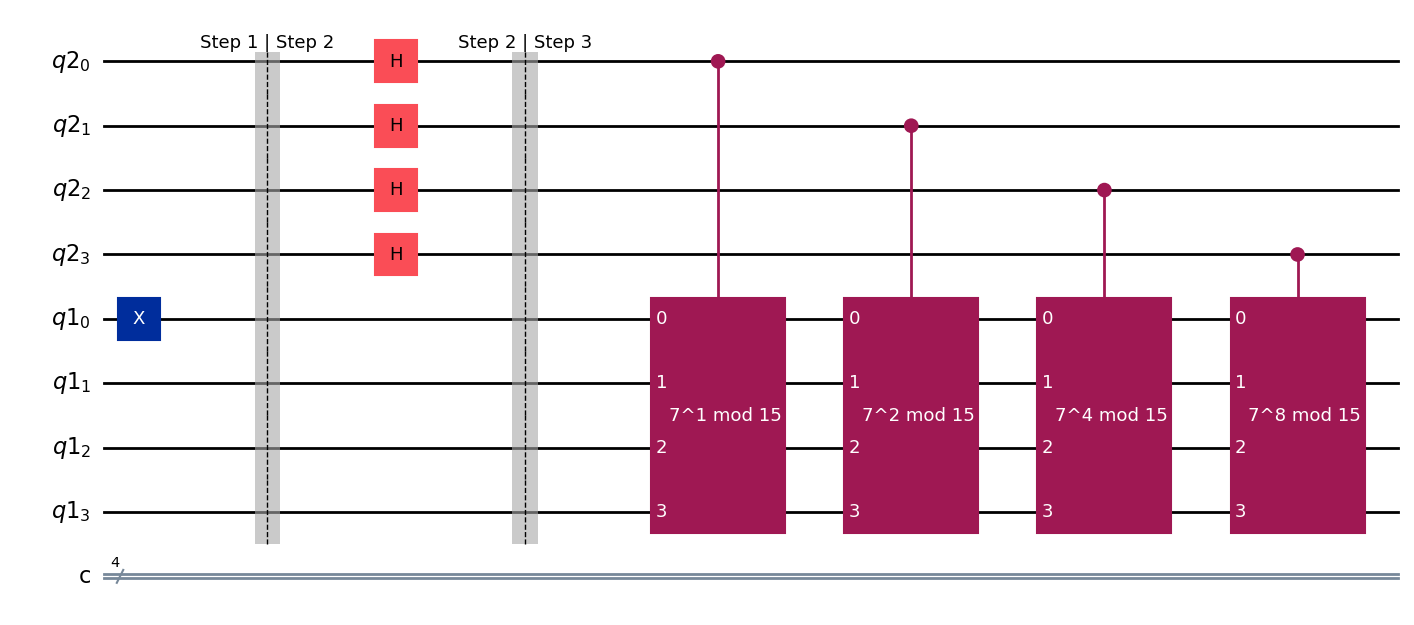

In [6]:
qc.barrier(label="Step 2 | Step 3")
for q in range(n_count):
    qc_cU = f_qc_U(2**q).control() # amod15(a, 2**q).control()
    qc.append(qc_cU, [q] + [n_count+i for i in range(reg1_size)])
qc.draw(output="mpl", style="iqp")

#### State after Step 3

\begin{align*}
|\psi_3\rangle & = (U_{7^8 mod 15}^3)(U_{7^4 mod 15}^2)(U_{7^2 mod 15}^1)(U_{7^1 mod 15}^0)|\psi_2\rangle \tag{definition} \\
& = (U_{7^8 mod 15}^3)(U_{7^4 mod 15}^2)(U_{7^2 mod 15}^1)(U_{7^1 mod 15}^0)|0001++++\rangle \tag{definition $|\psi_2\rangle$} \\
& = \frac{1}{\sqrt{2^1}}(U_{7^8 mod 15}^3)(U_{7^4 mod 15}^2)(U_{7^2 mod 15}^1)(|0001+++\rangle \otimes (|0\rangle + e^{2\pi i j/8}|1\rangle)) \tag{Apply U} \\
& = \frac{1}{\sqrt{2^2}}(U_{7^8 mod 15}^3)(U_{7^4 mod 15}^2)(|0001++\rangle (|0\rangle + e^{2\pi i 2j/8}|1\rangle) \otimes (|0\rangle + e^{2\pi i j/8}|1\rangle)) \tag{Apply U} \\
& = \frac{1}{\sqrt{2^3}}(U_{7^8 mod 15}^3)(|0001+\rangle (|0\rangle + e^{2\pi i 4j/8}|1\rangle) \otimes (|0\rangle + e^{2\pi i 2j/8}|1\rangle) \otimes (|0\rangle + e^{2\pi i j/8}|1\rangle)) \tag{Apply U} \\
& = \frac{1}{\sqrt{2^4}}(|0001+\rangle (|0\rangle + e^{2\pi i 8j/8}|1\rangle) \otimes (|0\rangle + e^{2\pi i 4j/8}|1\rangle) \otimes (|0\rangle + e^{2\pi i 2j/8}|1\rangle) \otimes (|0\rangle + e^{2\pi i j/8}|1\rangle)) \tag{Apply U} \\
& = \frac{1}{\sqrt{2^4}}(|0001\rangle (|0\rangle + e^{2\pi i 0.j_3 j_2 j_1 j_0}|1\rangle) \otimes (|0\rangle + e^{2\pi i 0.j_2 j_1 j_0}|1\rangle) \otimes (|0\rangle + e^{2\pi i 0.j_1 j_0}|1\rangle) \otimes (|0\rangle + e^{2\pi i 0.j_0}|1\rangle)) \tag{express j in binary} \\
& = |0001\rangle \otimes F_4|j_3 j_2 j_1 j_0\rangle \tag{QFT binary expansion} 
\end{align*}

### Step 4

Apply the **inverse QFT** to the first register.

#### Inverse QFT

As a reminder, every quantum operator is invertible. Consequently, we can invert the QFT, resulting in the **inverse QFT**. We can construct the inverse QFT by applying the inverse of each gate in the QFT in reverse order.

In [7]:
def qft_dagger(qc: QuantumCircuit, n: int) -> None:
    # Swap for little endian
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        # Inverse of controlled rotation is inverse rotation
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        # Hadamard is own inverse
        qc.h(j)

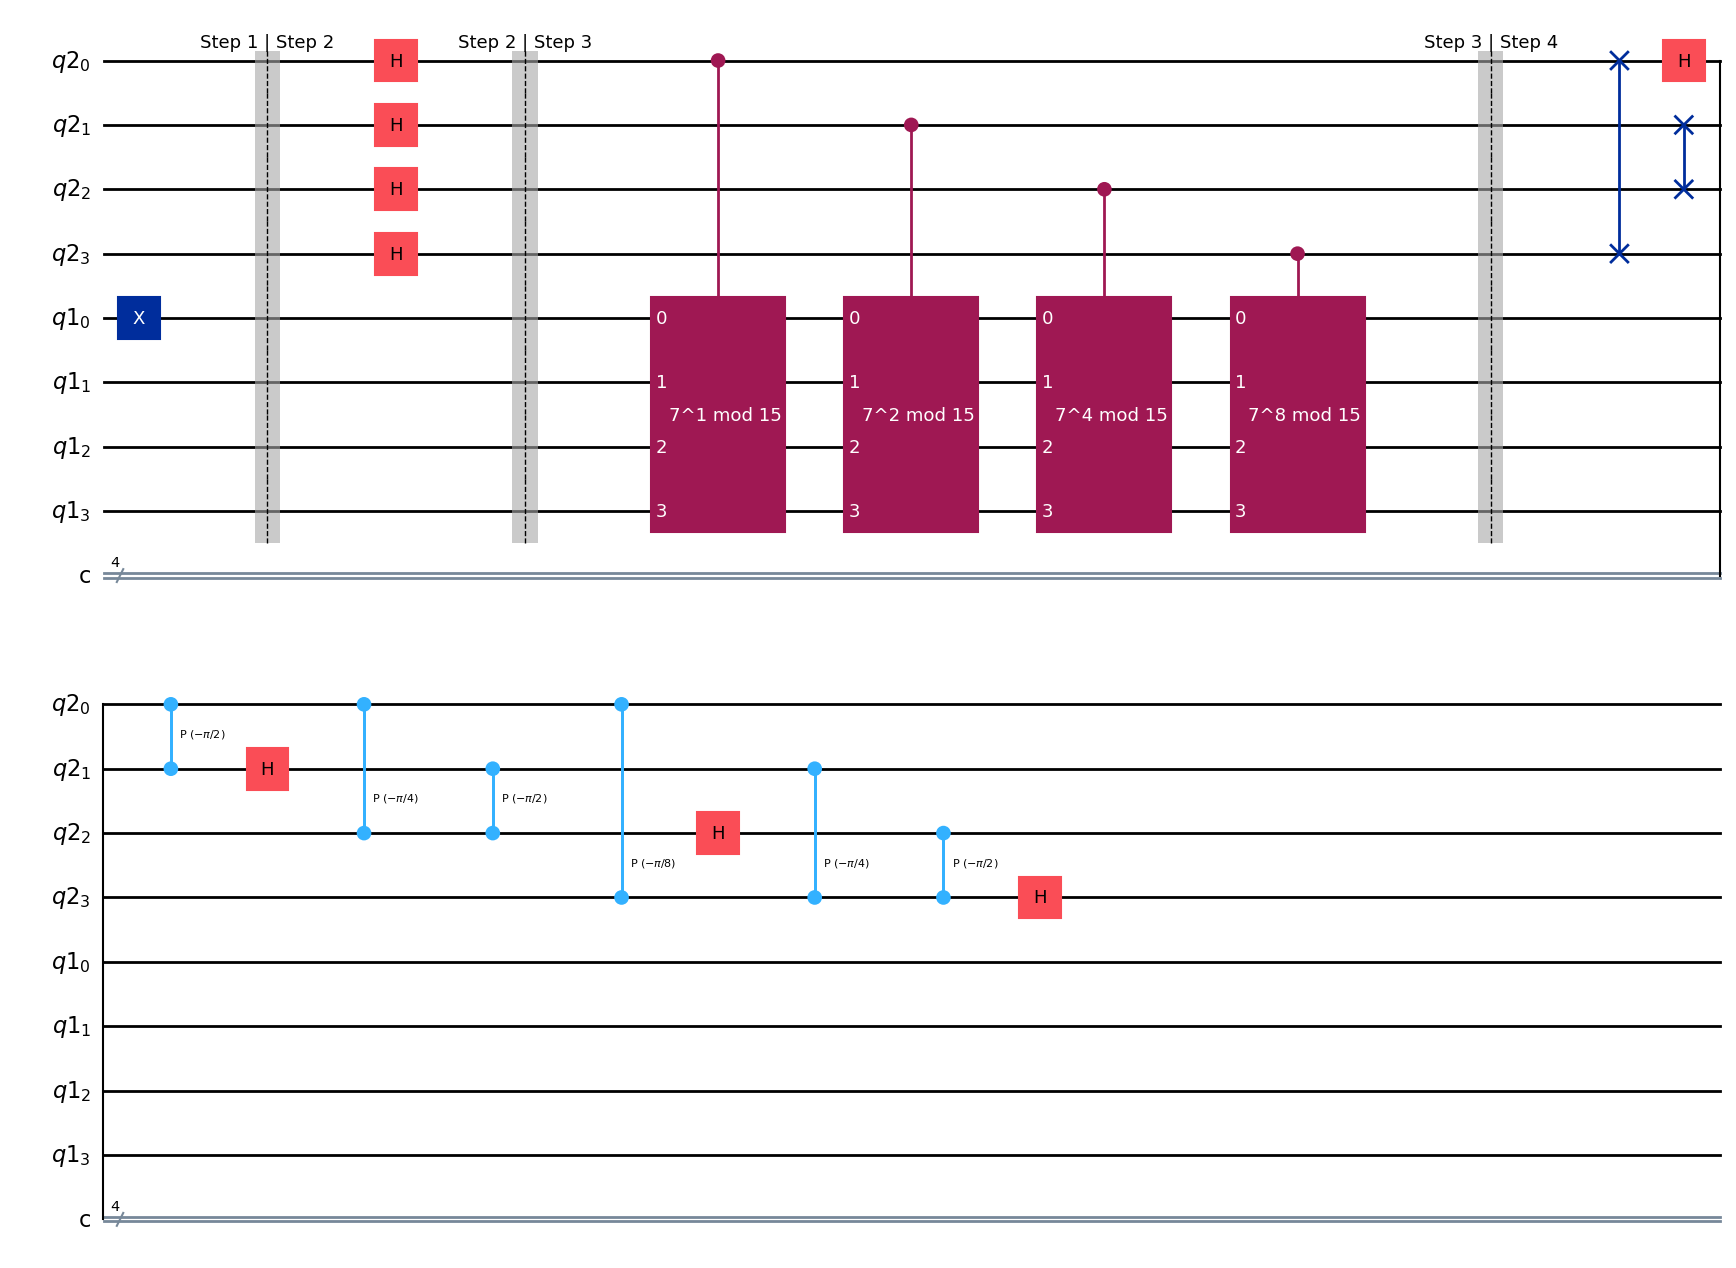

In [8]:
# Step 4: Perform inverse QFT
qc.barrier(label="Step 3 | Step 4")
qft_dagger(qc, 4)
qc.draw(output="mpl", style="iqp")

#### State after Step 4

\begin{align*}
|\psi_4\rangle & = (I \otimes F_4^{-1}) |\psi_3\rangle \tag{definition} \\
& = (I \otimes F_4^{-1})(|0001\rangle \otimes F_4|j_3 j_2 j_1 j_0\rangle) \tag{definition $|\psi_3\rangle$} \\
& = |0001\rangle \otimes |j_3 j_2 j_1 j_0\rangle \tag{Inverse QFT}
\end{align*}

### Step 5

Measure the first register.

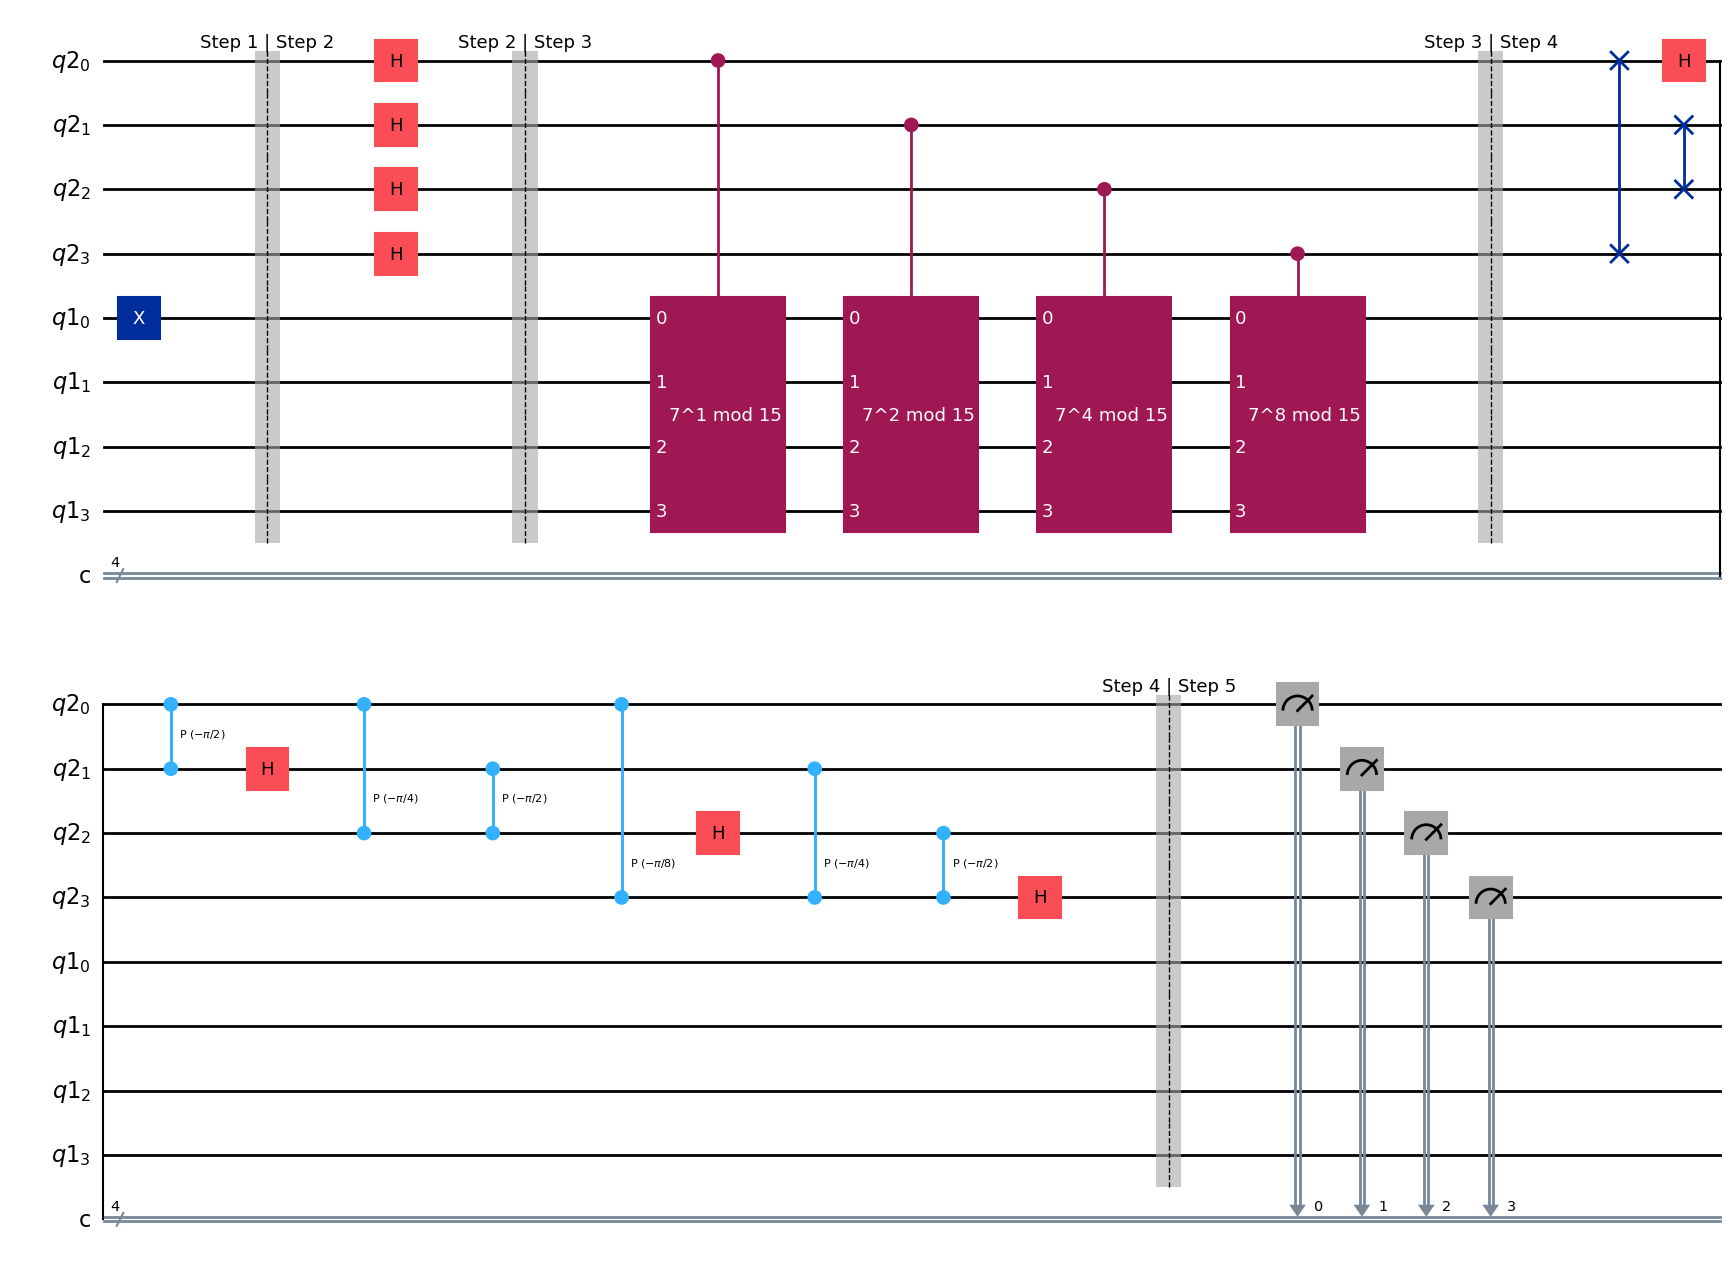

In [9]:
# Step 5: Measure first register
qc.barrier(label="Step 4 | Step 5")
for n in range(n_count):
    qc.measure(n, n)
qc.draw(output="mpl", style="iqp")

#### State after Step 5

We have $|j_3 j_2 j_1 j_0\rangle$. Measurement will produce a multiple of $j_3 j_2 j_1 j_0$

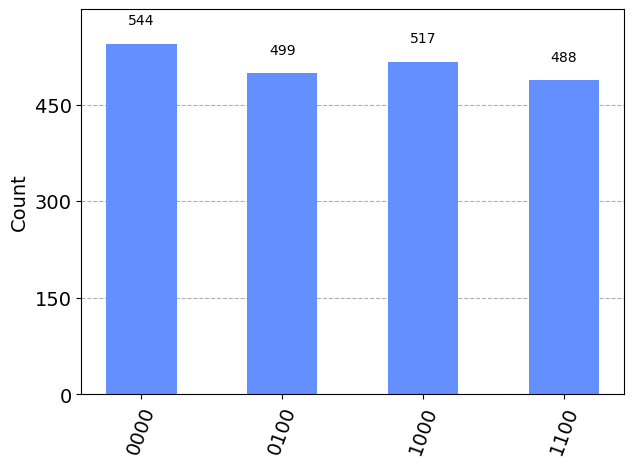

In [10]:
t_qpe = transpile(qc, sim)
results = sim.run(t_qpe, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

#### Interpreting the results

1. The order of $7^x \, (\text{mod} \, 15)$ is $4$.
2. So our answers should all be multiples of $4$.

In [11]:
def display_counts(counts):
    rows, measured_phases = [], []
    for output in counts:
        n_count = len(output)
        decimal = int(output, 2)  # Convert (base 2) string to decimal
        phase = decimal/(2**n_count)  # Find corresponding eigenvalue
        measured_phases.append(phase)
        # Add these values to the rows in our table:
        rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                     f"{decimal}/{2**n_count} = {phase:.2f}"])
    # Print the rows in a table
    headers=["Register Output", "Phase"]
    df = pd.DataFrame(rows, columns=headers)
    return df

display_counts(counts)

,Register Output,Phase
0,1000(bin) = 8(dec),8/16 = 0.50
1,0000(bin) = 0(dec),0/16 = 0.00
2,1100(bin) = 12(dec),12/16 = 0.75
3,0100(bin) = 4(dec),4/16 = 0.25


### Putting it Together

We gather all the steps together now.

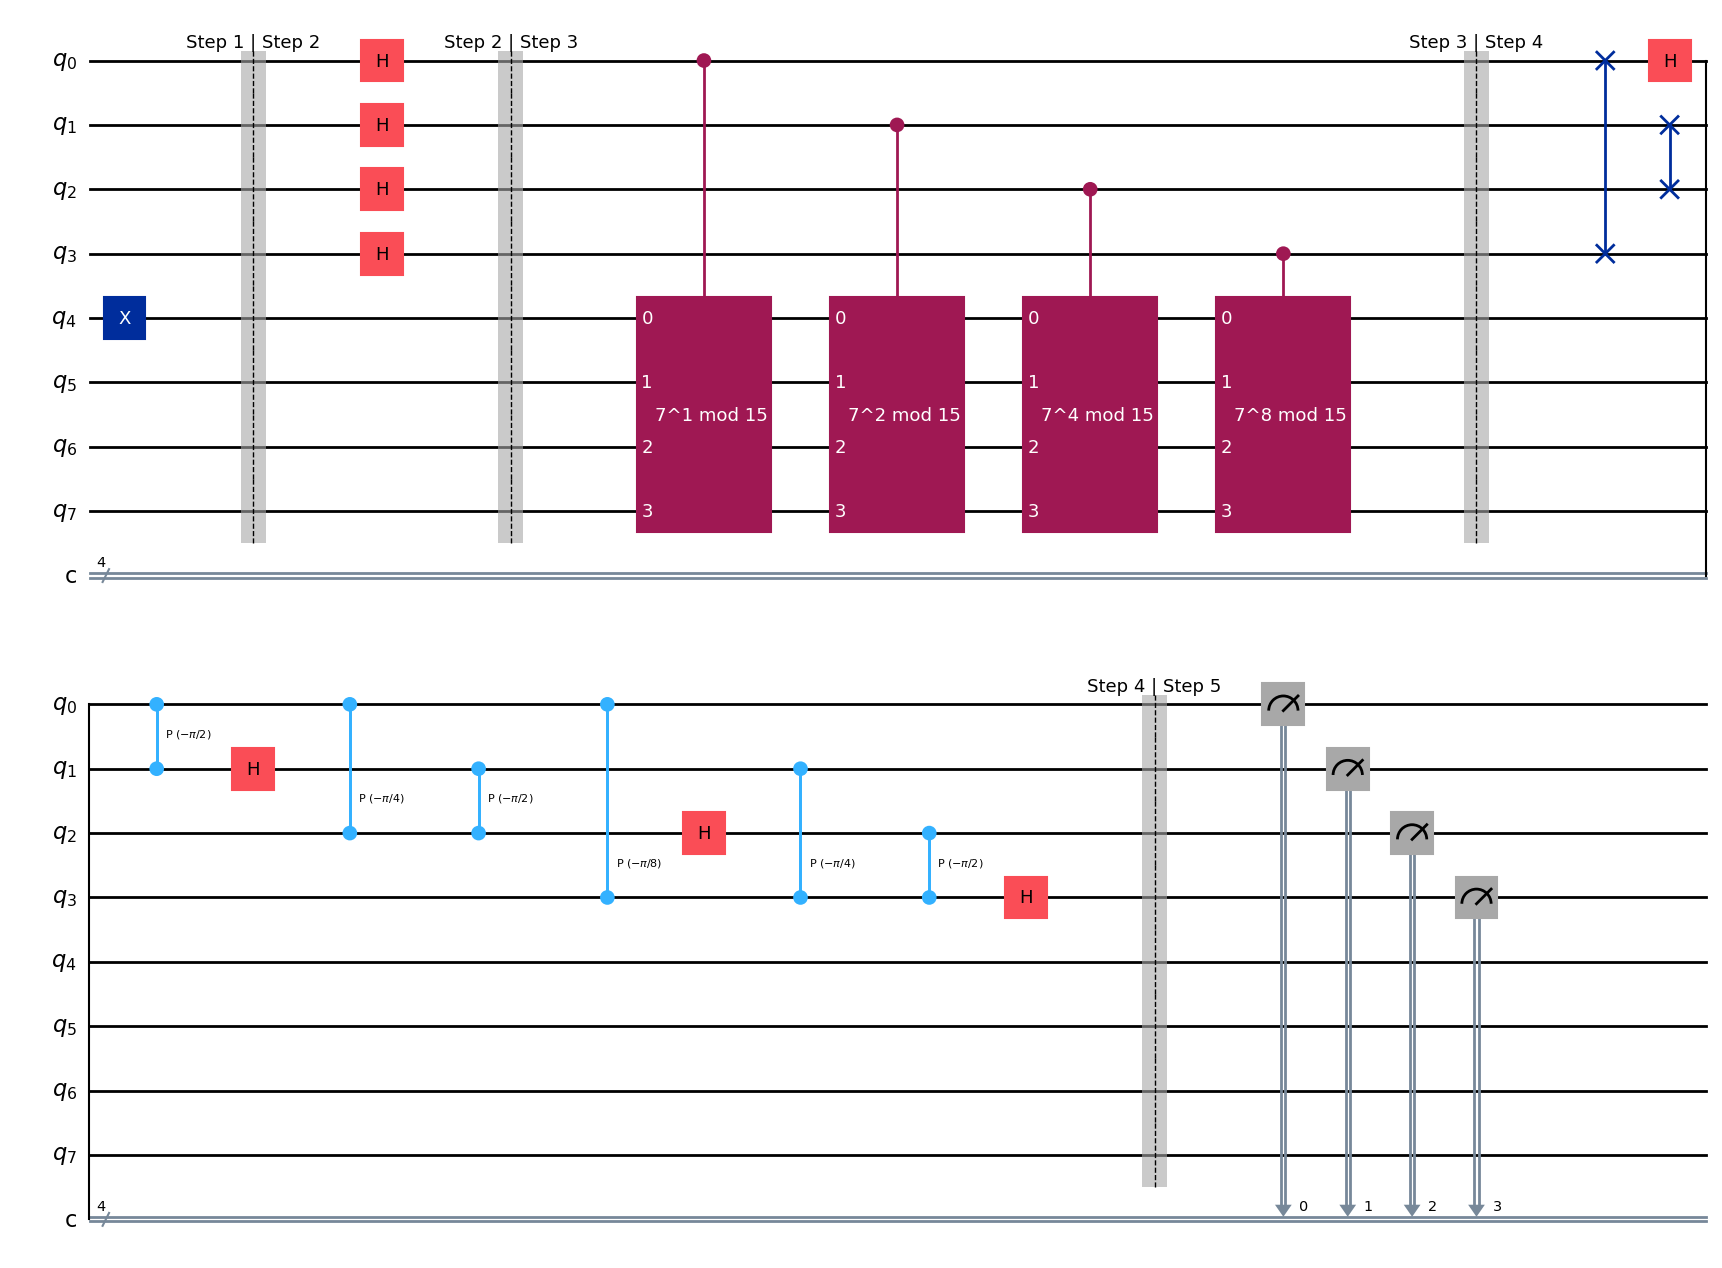

In [12]:
def qpe(f_qc_U: Callable, n_count: int) -> QuantumCircuit:
    # Create and set up circuit
    reg1_size = f_qc_U(0).num_qubits
    qc = QuantumCircuit(n_count+reg1_size, n_count)

    # Step 1: Prepare our eigenstate |1>:
    qc.x(n_count)
    
    # Step 2: Apply H-Gates to counting qubits.
    qc.barrier(label="Step 1 | Step 2")
    for qubit in range(n_count):
        qc.h(qubit)
    
    # Step 3: Do the controlled-U operations:
    qc.barrier(label="Step 2 | Step 3")
    for q in range(n_count):
        qc_cU = f_qc_U(2**q).control() # amod15(a, 2**q).control()
        qc.append(qc_cU, [q] + [n_count+i for i in range(reg1_size)])
    
    # Step 4: Perform inverse QFT
    qc.barrier(label="Step 3 | Step 4")
    qft_dagger(qc, 4)
    
    # Step 5: Measure first register
    qc.barrier(label="Step 4 | Step 5")
    for n in range(n_count):
        qc.measure(n, n)
    return qc

qc_qpe = qpe(lambda q: amod15(7, q), 4)
qc_qpe.draw(output="mpl", style="iqp")

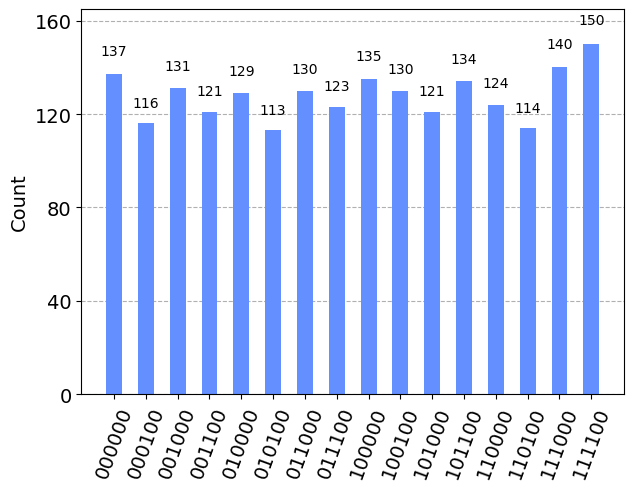

In [13]:
qc_qpe = qpe(lambda q: amod15(7, q), 6)
t_qpe = transpile(qc_qpe, sim)
results = sim.run(t_qpe, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts) # note how the last 2 bits are 00

In [14]:
display_counts(counts)

,Register Output,Phase
0,111000(bin) = 56(dec),56/64 = 0.88
1,110100(bin) = 52(dec),52/64 = 0.81
2,011100(bin) = 28(dec),28/64 = 0.44
3,100000(bin) = 32(dec),32/64 = 0.50
4,111100(bin) = 60(dec),60/64 = 0.94
5,010000(bin) = 16(dec),16/64 = 0.25
6,101000(bin) = 40(dec),40/64 = 0.62
7,000100(bin) = 4(dec),4/64 = 0.06
8,001100(bin) = 12(dec),12/64 = 0.19
9,001000(bin) = 8(dec),8/64 = 0.12


## Summary

1. We have introduced the QPE algorithm.